# Detailed Data Cleaning/Visualization

*A blog post about the final end-to-end solution (21st place) is available [here](http://alanpryorjr.com), and the source code is [on my github](https://github.com/apryor6/Kaggle-Competition-Santander)*

*This is a Python version of a kernel I wrote in R for this dataset found [here](https://www.kaggle.com/apryor6/santander-product-recommendation/detailed-cleaning-visualization). There are some slight differences between how missing values are treated in Python and R, so the two kernels are not exactly the same, but I have tried to make them as similar as possible. This was done as a convenience to anybody who wanted to use my cleaned data as a starting point but prefers Python to R. It also is educational to compare how the same task can be accomplished in either language.*

The goal of this competition is to predict which new Santander products, if any, a customer will purchase in the following month. Here, I will do some data cleaning, adjust some features, and do some visualization to get a sense of what features might be important predictors. I won't be building a predictive model in this kernel, but I hope this gives you some insight/ideas and gets you excited to build your own model.

Let's get to it

## First Glance
Limit the number of rows read in to avoid memory crashes with the kernel

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
limit_rows   = 7000000
df           = pd.read_csv("./train_ver2.csv",dtype={"sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str}, nrows=limit_rows)
unique_ids   = pd.Series(df["ncodpers"].unique())
limit_people = int(1.2e4)
unique_id    = unique_ids.sample(n=limit_people)
df           = df[df.ncodpers.isin(unique_id)]
df.describe()

/Users/chuuhtetnaing/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ncodpers,indrel,tipodom,cod_prov,ind_actividad_cliente,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
count,9.296400e+04,92588.000000,92588.0,91933.000000,92588.000000,7.639000e+04,92964.000000,92964.0,92964.000000,92964.000000,...,92964.000000,92964.000000,92964.000000,92964.000000,92964.000000,92964.000000,92964.000000,92756.000000,92756.000000,92964.000000
mean,8.093955e+05,1.151359,1.0,26.655999,0.485711,1.314788e+05,0.000108,0.0,0.707328,0.000323,...,0.007401,0.009961,0.003647,0.056527,0.048513,0.026118,0.004163,0.058260,0.063640,0.130814
std,4.195532e+05,3.848429,0.0,12.717103,0.499798,1.364495e+05,0.010371,0.0,0.454992,0.017961,...,0.085709,0.099306,0.060277,0.230938,0.214850,0.159486,0.064386,0.234236,0.244112,0.337199
min,1.603600e+04,1.000000,1.0,1.000000,0.000000,6.611580e+03,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.229385e+05,1.000000,1.0,15.000000,0.000000,6.916284e+04,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.263590e+05,1.000000,1.0,28.000000,0.000000,1.022453e+05,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.167300e+06,1.000000,1.0,35.000000,1.000000,1.546464e+05,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.495476e+06,99.000000,1.0,52.000000,1.000000,7.026124e+06,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We have a number of demographics for each individual as well as the products they currently own. To make a test set, I will separate the last month from this training data, and create a feature that indicates whether or not a product was newly purchased. First convert the dates. There's `fecha_dato`, the row-identifier date, and `fecha_alta`, the date that the customer joined.

In [3]:
df["fecha_dato"] = pd.to_datetime(df["fecha_dato"],format="%Y-%m-%d")
df["fecha_alta"] = pd.to_datetime(df["fecha_alta"],format="%Y-%m-%d")
df["fecha_dato"].unique()

array(['2015-01-28T00:00:00.000000000', '2015-02-28T00:00:00.000000000',
       '2015-03-28T00:00:00.000000000', '2015-04-28T00:00:00.000000000',
       '2015-05-28T00:00:00.000000000', '2015-06-28T00:00:00.000000000',
       '2015-07-28T00:00:00.000000000', '2015-08-28T00:00:00.000000000',
       '2015-09-28T00:00:00.000000000', '2015-10-28T00:00:00.000000000'],
      dtype='datetime64[ns]')

I printed the values just to double check the dates were in standard Year-Month-Day format. I expect that customers will be more likely to buy products at certain months of the year (Christmas bonuses?), so let's add a month column. I don't think the month that they joined matters, so just do it for one.

In [4]:
df["month"] = pd.DatetimeIndex(df["fecha_dato"]).month
df["age"]   = pd.to_numeric(df["age"], errors="coerce")

Are there any columns missing values?

In [5]:
df.isnull().any()

fecha_dato               False
ncodpers                 False
ind_empleado              True
pais_residencia           True
sexo                      True
age                       True
fecha_alta                True
ind_nuevo                 True
antiguedad               False
indrel                    True
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                   True
indext                    True
conyuemp                  True
canal_entrada             True
indfall                   True
tipodom                   True
cod_prov                  True
nomprov                   True
ind_actividad_cliente     True
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp

Definitely. Onto data cleaning.

## Data Cleaning

Going down the list, start with `age`

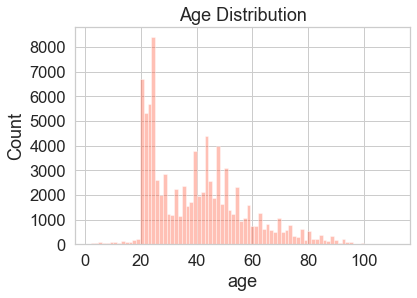

In [6]:
import matplotlib.pyplot as plt
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df["age"].dropna(),
                 bins=80,
                 kde=False,
                 color="tomato")
    plt.title("Age Distribution")
    plt.ylabel("Count")

In addition to NA, there are people with very small and very high ages.
It's also interesting that the distribution is bimodal. There are a large number of university aged students, and then another peak around middle-age. Let's separate the distribution and move the outliers to the mean of the closest one.

In [7]:
df.loc[df.age < 18,"age"]  = df.loc[(df.age >= 18) & (df.age <= 30),"age"].mean(skipna=True)
df.loc[df.age > 100,"age"] = df.loc[(df.age >= 30) & (df.age <= 100),"age"].mean(skipna=True)
df["age"].fillna(df["age"].mean(),inplace=True)
df["age"]                  = df["age"].astype(int)

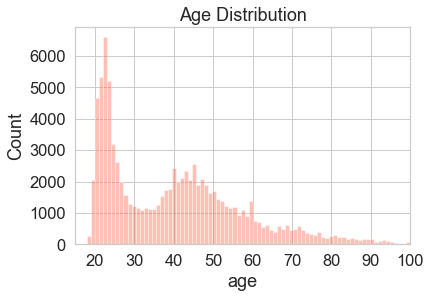

In [8]:
import matplotlib.pyplot as plt
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df["age"].dropna(),
                 bins=80,
                 kde=False,
                 color="tomato")
    plt.title("Age Distribution")
    plt.ylabel("Count")
    plt.xlim((15,100))

Looks better.  

Next `ind_nuevo`, which indicates whether a customer is new or not. How many missing values are there?

In [9]:
df["ind_nuevo"].isnull().sum()

376

Let's see if we can fill in missing values by looking how many months of history these customers have.

In [10]:
df[df["ncodpers"] == 1031676]

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,month


In [11]:
df.loc[df["ind_nuevo"].isnull(),:].groupby("ncodpers", sort=False).size().head(30)

ncodpers
1054659    3
1021686    5
1103434    3
1125507    6
949781     5
950277     2
943119     5
946714     1
899612     3
878542     5
880082     6
877318     6
885524     6
918135     2
917243     1
980981     6
1004660    3
1008773    4
965320     1
1293222    3
1293445    1
1286631    4
1289009    1
1253542    5
1258779    3
1276066    5
1355956    1
1371840    5
1359187    1
1363751    3
dtype: int64

In [12]:
months_active = df.loc[df["ind_nuevo"].isnull(),:].groupby("ncodpers", sort=False).size()
months_active.max()

6

Looks like these are all new customers, so replace accordingly.

In [13]:
df.loc[df["ind_nuevo"].isnull(),"ind_nuevo"] = 1

Now, `antiguedad`

In [14]:
df.antiguedad = pd.to_numeric(df.antiguedad,errors="coerce")
np.sum(df["antiguedad"].isnull())

376

That number again. Probably the same people that we just determined were new customers. Double check.

In [15]:
df.loc[df["antiguedad"].isnull(),"ind_nuevo"]

4281       1
26896      1
40687      1
52837      1
88139      1
          ..
3688557    1
3708062    1
3743897    1
3754002    1
3755917    1
Name: ind_nuevo, Length: 376, dtype: object

In [16]:
df.loc[df["antiguedad"].isnull(),"ind_nuevo"].describe()

count     376
unique      1
top         1
freq      376
Name: ind_nuevo, dtype: int64

Yup, same people. Let's give them minimum seniority.

In [17]:
df.loc[df.antiguedad.isnull(),"antiguedad"] = df.antiguedad.min()
df.loc[df.antiguedad <0, "antiguedad"]      = 0 # Thanks @StephenSmith for bug-find

Some entries don't have the date they joined the company. Just give them something in the middle of the pack

In [18]:
dates=df.loc[:,"fecha_alta"].sort_values().reset_index()
median_date = int(np.median(dates.index.values))
df.loc[df.fecha_alta.isnull(),"fecha_alta"] = dates.loc[median_date,"fecha_alta"]
df["fecha_alta"].describe()

count                   92964
unique                   3969
top       2014-10-03 00:00:00
freq                      534
first     1995-02-17 00:00:00
last      2015-10-30 00:00:00
Name: fecha_alta, dtype: object

Next is `indrel`, which indicates:

> 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)

This sounds like a promising feature. I'm not sure if primary status is something the customer chooses or the company assigns, but either way it seems intuitive that customers who are dropping down are likely to have different purchasing behaviors than others.

In [19]:
pd.Series([i for i in df.indrel]).value_counts()

1.0     92445
99.0      143
dtype: int64

Fill in missing with the more common status.

In [20]:
df.loc[df.indrel.isnull(),"indrel"] = 1

> tipodom	- Addres type. 1, primary address
 cod_prov	- Province code (customer's address)

`tipodom` doesn't seem to be useful, and the province code is not needed because the name of the province exists in `nomprov`.

In [21]:
df.drop(["tipodom","cod_prov"],axis=1,inplace=True)

Quick check back to see how we are doing on missing values

In [22]:
df.isnull().any()

fecha_dato               False
ncodpers                 False
ind_empleado              True
pais_residencia           True
sexo                      True
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                   True
indext                    True
conyuemp                  True
canal_entrada             True
indfall                   True
nomprov                   True
ind_actividad_cliente     True
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco_fin_ult1        False
ind_deme

Getting closer.

In [23]:
np.sum(df["ind_actividad_cliente"].isnull())

376

By now you've probably noticed that this number keeps popping up. A handful of the entries are just bad, and should probably just be excluded from the model. But for now I will just clean/keep them.

In [101]:
df.loc[df.ind_actividad_cliente.isnull(),"ind_actividad_cliente"] = \
df["ind_actividad_cliente"].median()

In [102]:
df.nomprov.unique()

array(['ZARAGOZA', 'BARCELONA', 'VALENCIA', 'TOLEDO', 'ZAMORA',
       'CORUÑA, A', 'MADRID', 'SALAMANCA', 'SEVILLA', 'OURENSE',
       'PONTEVEDRA', 'PALMAS, LAS', 'VALLADOLID', 'CASTELLON',
       'TARRAGONA', 'SEGOVIA', 'LUGO', 'MALAGA', 'CANTABRIA', 'CACERES',
       'LERIDA', 'MURCIA', 'BADAJOZ', 'GRANADA', 'BALEARS, ILLES',
       'CIUDAD REAL', 'ALBACETE', 'BURGOS', 'CADIZ', 'GIRONA', 'CUENCA',
       'HUESCA', 'PALENCIA', 'NAVARRA', 'ALICANTE', 'CORDOBA', 'HUELVA',
       'ASTURIAS', 'SANTA CRUZ DE TENERIFE', 'ALMERIA', 'JAEN', 'TERUEL',
       'BIZKAIA', 'ALAVA', nan, 'RIOJA, LA', 'AVILA', 'LEON', 'SORIA',
       'GUADALAJARA', 'GIPUZKOA', 'MELILLA', 'CEUTA'], dtype=object)

There was an issue with the unicode character ñ in [A Coruña](https://en.wikipedia.org/wiki/A_Coruña). I'll manually fix it, but if anybody knows a better way to catch cases like this I would be very glad to hear it in the comments.

In [103]:
df.loc[df.nomprov=="CORU\xc3\x91A, A","nomprov"] = "CORUNA, A"

There's some rows missing a city that I'll relabel

In [104]:
df.loc[df.nomprov.isnull(),"nomprov"] = "UNKNOWN"

Now for gross income, aka `renta`

In [105]:
df.renta.isnull().sum()

16670

Here is a feature that is missing a lot of values. Rather than just filling them in with a median, it's probably more accurate to break it down region by region. To that end, let's take a look at the median income by region, and in the spirit of the competition let's color it like the Spanish flag.

In [106]:
#df.loc[df.renta.notnull(),:].groupby("nomprov").agg([{"Sum":sum},{"Mean":mean}])
incomes = df.loc[df.renta.notnull(),:].groupby("nomprov").agg({"renta":{"MedianIncome":median}})
incomes.sort_values(by=("renta","MedianIncome"),inplace=True)
incomes.reset_index(inplace=True)
incomes.nomprov = incomes.nomprov.astype("category")
# incomes.nomprov = pd.api.types.CategoricalDtype(categories=[i for i in df.nomprov.unique()],ordered=False)
incomes.head()

,nomprov,renta
,,MedianIncome
0,CIUDAD REAL,61285.35
1,LERIDA,63749.04
2,LUGO,64381.23
3,ALMERIA,65699.34
4,BADAJOZ,68151.06


([<matplotlib.axis.YTick at 0x1a34f41d30>,
 <a list of 5 Text yticklabel objects>)

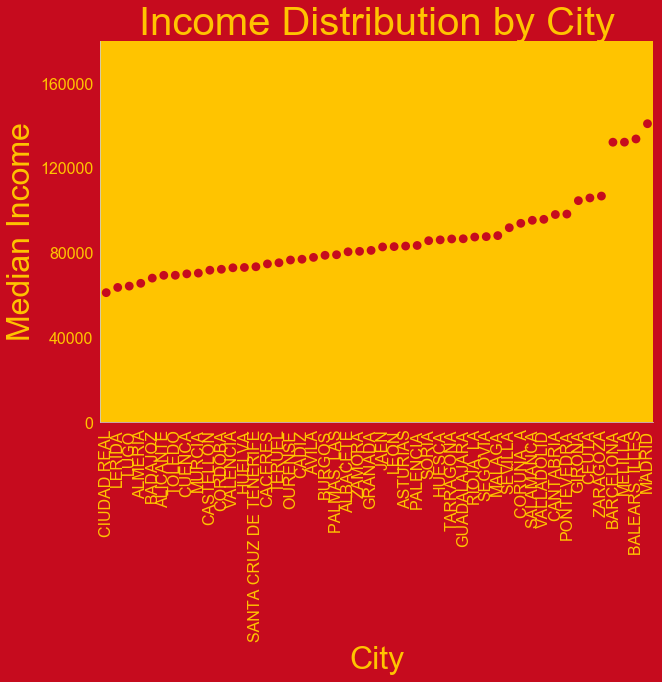

In [107]:
with sns.axes_style({
        "axes.facecolor":   "#ffc400",
        "axes.grid"     :    False,
        "figure.facecolor": "#c60b1e"}):
    h = sns.factorplot(data=incomes,
                   x="nomprov",
                   y=("renta","MedianIncome"),
                   order=(i for i in incomes.nomprov),
                   size=6,
                   aspect=1.5,
                   scale=1.0,
                   color="#c60b1e",
                   linestyles="None")
plt.xticks(rotation=90)
plt.tick_params(labelsize=16,labelcolor="#ffc400")#
plt.ylabel("Median Income",size=32,color="#ffc400")
plt.xlabel("City",size=32,color="#ffc400")
plt.title("Income Distribution by City",size=40,color="#ffc400")
plt.ylim(0,180000)
plt.yticks(range(0,180000,40000))

There's a lot of variation, so I think assigning missing incomes by providence is a good idea. First group the data by city, and reduce to get the median. This intermediate data frame is joined by the original city names to expand the aggregated median incomes, ordered so that there is a 1-to-1 mapping between the rows, and finally the missing values are replaced.

In [108]:
grouped        = df.groupby("nomprov").agg({"renta":lambda x: x.median(skipna=True)}).reset_index()
new_incomes    = pd.merge(df,grouped,how="inner",on="nomprov").loc[:, ["nomprov","renta_y"]]
new_incomes    = new_incomes.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("nomprov")
df.sort_values("nomprov",inplace=True)
df             = df.reset_index()
new_incomes    = new_incomes.reset_index()

In [109]:
df.loc[df.renta.isnull(),"renta"] = new_incomes.loc[df.renta.isnull(),"renta"].reset_index()
df.loc[df.renta.isnull(),"renta"] = df.loc[df.renta.notnull(),"renta"].median()
df.sort_values(by="fecha_dato",inplace=True)

The next columns with missing data I'll look at are features, which are just a boolean indicator as to whether or not that product was owned that month. Starting with `ind_nomina_ult1`..

In [110]:
df.ind_nomina_ult1.isnull().sum()

194

I could try to fill in missing values for products by looking at previous months, but since it's such a small number of values for now I'll take the cheap way out.

In [111]:
df.loc[df.ind_nomina_ult1.isnull(), "ind_nomina_ult1"] = 0
df.loc[df.ind_nom_pens_ult1.isnull(), "ind_nom_pens_ult1"] = 0

There's also a bunch of character columns that contain empty strings. In R, these are kept as empty strings instead of NA like in pandas. I originally worked through the data with missing values first in R, so if you are wondering why I skipped some NA columns here that's why. I'll take care of them now. For the most part, entries with NA will be converted to an unknown category.  
First I'll get only the columns with missing values. Then print the unique values to determine what I should fill in with.

In [112]:
string_data = df.select_dtypes(include=["object"])
missing_columns = [col for col in string_data if string_data[col].isnull().any()]
for col in missing_columns:
    print("Unique values for {0}:\n{1}\n".format(col,string_data[col].unique()))
del string_data

Unique values for ind_empleado:
['N' nan 'A' 'F']

Unique values for pais_residencia:
['ES' 'DE' nan 'SV' 'PY' 'AR' 'VE' 'CO' 'CL' 'EC' 'PA' 'FR' 'PL' 'KE' 'IN'
 'MX' 'BR' 'CA' 'GB' 'IT' 'MR' 'AE' 'PT' 'IE' 'RO' 'UA' 'ML' 'GQ' 'CR'
 'US' 'CH' 'PE']

Unique values for sexo:
['V' 'H' nan]

Unique values for ult_fec_cli_1t:
[nan '2015-07-06' '2015-07-23' '2015-07-10' '2015-07-22' '2015-07-09'
 '2015-07-13' '2015-07-29' '2015-07-28' '2015-07-01' '2015-07-20'
 '2015-07-14' '2015-07-08' '2015-08-19' '2015-08-13' '2015-08-11'
 '2015-08-26' '2015-08-03' '2015-08-21' '2015-08-05' '2015-08-20'
 '2015-08-28' '2015-08-27' '2015-08-17' '2015-08-04' '2015-08-18'
 '2015-08-24' '2015-08-25' '2015-09-29' '2015-09-14' '2015-09-01'
 '2015-09-22' '2015-09-07' '2015-09-02' '2015-09-11' '2015-09-09'
 '2015-09-24' '2015-09-18' '2015-09-25' '2015-09-28' '2015-09-17'
 '2015-09-23' '2015-10-09' '2015-10-15' '2015-10-07' '2015-10-16'
 '2015-10-13' '2015-10-27' '2015-10-20' '2015-10-01' '2015-10-26'
 '2015-10-08'

Okay, based on that and the definitions of each variable, I will fill the empty strings either with the most common value or create an unknown category based on what I think makes more sense.

In [113]:
df.loc[df.indfall.isnull(),"indfall"] = "N"
df.loc[df.tiprel_1mes.isnull(),"tiprel_1mes"] = "A"
df.tiprel_1mes = df.tiprel_1mes.astype("category")

# As suggested by @StephenSmith
map_dict = { 1.0  : "1",
            "1.0" : "1",
            "1"   : "1",
            "3.0" : "3",
            "P"   : "P",
            3.0   : "3",
            2.0   : "2",
            "3"   : "3",
            "2.0" : "2",
            "4.0" : "4",
            "4"   : "4",
            "2"   : "2"}

df.indrel_1mes.fillna("P",inplace=True)
df.indrel_1mes = df.indrel_1mes.apply(lambda x: map_dict.get(x,x))
df.indrel_1mes = df.indrel_1mes.astype("category")


unknown_cols = [col for col in missing_columns if col not in ["indfall","tiprel_1mes","indrel_1mes"]]
for col in unknown_cols:
    df.loc[df[col].isnull(),col] = "UNKNOWN"

Let's check back to see if we missed anything

In [114]:
df.isnull().any()

index                    False
fecha_dato               False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                     False
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
ult_fec_cli_1t           False
indrel_1mes              False
tiprel_1mes              False
indresi                  False
indext                   False
conyuemp                 False
canal_entrada            False
indfall                  False
nomprov                  False
ind_actividad_cliente    False
renta                    False
segmento                 False
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco

Convert the feature columns into integer values (you'll see why in a second), and we're done cleaning

In [115]:
feature_cols = df.iloc[:1,].filter(regex="ind_+.*ult.*").columns.values
for col in feature_cols:
    df[col] = df[col].astype(int)

Now for the main event. To study trends in customers adding or removing services, I will create a label for each product and month that indicates whether a customer added, dropped or maintained that service in that billing cycle. I will do this by assigning a numeric id to each unique time stamp, and then matching each entry with the one from the previous month. The difference in the indicator value for each product then gives the desired value.  

In [116]:
unique_months = pd.DataFrame(pd.Series(df.fecha_dato.unique()).sort_values()).reset_index(drop=True)
unique_months["month_id"] = pd.Series(range(1,1+unique_months.size)) # start with month 1, not 0 to match what we already have
unique_months["month_next_id"] = 1 + unique_months["month_id"]
unique_months.rename(columns={0:"fecha_dato"},inplace=True)
df = pd.merge(df,unique_months,on="fecha_dato")

Now I'll build a function that will convert differences month to month into a meaningful label. Each month, a customer can either maintain their current status with a particular product, add it, or drop it.

In [117]:
def status_change(x):
    diffs = x.diff().fillna(0)# first occurrence will be considered Maintained, 
    #which is a little lazy. A better way would be to check if 
    #the earliest date was the same as the earliest we have in the dataset
    #and consider those separately. Entries with earliest dates later than that have 
    #joined and should be labeled as "Added"
    label = ["Added" if i==1 \
         else "Dropped" if i==-1 \
         else "Maintained" for i in diffs]
    return label

Now we can actually apply this function to each features using `groupby` followed by `transform` to broadcast the result back

In [118]:
# df.loc[:, feature_cols] = df..groupby("ncodpers").apply(status_change)
df.loc[:, feature_cols] = df.loc[:, [i for i in feature_cols]+["ncodpers"]].groupby("ncodpers").transform(status_change)

I'm only interested in seeing what influences people adding or removing services, so I'll trim away any instances of "Maintained".

In [119]:
df = pd.melt(df, id_vars   = [col for col in df.columns if col not in feature_cols],
            value_vars= [col for col in feature_cols])
df = df.loc[df.value!="Maintained",:]
df.shape

(7320, 28)

And we're done! I hope you found this useful, and if you want to checkout the rest of visualizations I made you can find them [here](https://www.kaggle.com/apryor6/santander-product-recommendation/detailed-cleaning-visualization).

([<matplotlib.axis.YTick at 0x1a7abe0a20>,
 <a list of 5 Text yticklabel objects>)

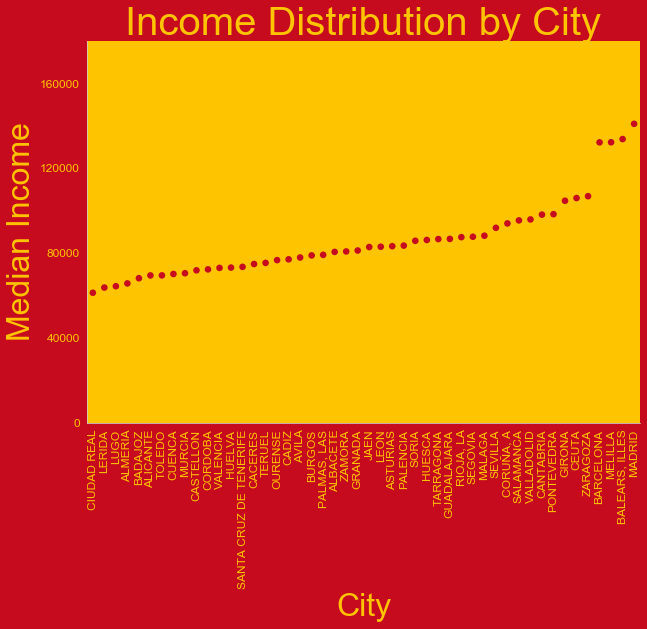

In [120]:
# For thumbnail
pylab.rcParams['figure.figsize'] = (6, 4)
with sns.axes_style({
        "axes.facecolor":   "#ffc400",
        "axes.grid"     :    False,
        "figure.facecolor": "#c60b1e"}):
    h = sns.factorplot(data=incomes,
                   x="nomprov",
                   y=("renta","MedianIncome"),
                   order=(i for i in incomes.nomprov),
                   size=6,
                   aspect=1.5,
                   scale=0.75,
                   color="#c60b1e",
                   linestyles="None")
plt.xticks(rotation=90)
plt.tick_params(labelsize=12,labelcolor="#ffc400")#
plt.ylabel("Median Income",size=32,color="#ffc400")
plt.xlabel("City",size=32,color="#ffc400")
plt.title("Income Distribution by City",size=40,color="#ffc400")
plt.ylim(0,180000)
plt.yticks(range(0,180000,40000))